In [267]:
# url = "https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"
# !wget $url

In [268]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Prepration 

In [269]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [270]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.columns[df.dtypes=='object'])

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [271]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

In [272]:
df.totalcharges = df.totalcharges.fillna(0)

In [273]:
df.churn = (df.churn == 'yes').astype(int)

# Setting up the validation framework

In [274]:
from sklearn.model_selection import train_test_split

In [275]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [276]:
len(df_full_train), len(df_test)

(5634, 1409)

In [277]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [278]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [279]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [280]:
y_train = df_train.churn.values
y_val = df_test.churn.values
y_test = df_val.churn.values

In [281]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

# EDA

In [282]:
df_full_train = df_full_train.reset_index(drop=True)

In [283]:
df_full_train.churn.value_counts(normalize=True)

0    0.730032
1    0.269968
Name: churn, dtype: float64

In [284]:
global_churn_rate = df_full_train.churn.mean()
round(global_churn_rate, 2)

0.27

In [285]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [286]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice','onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [287]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

# Feature importcance : Churn rate and risk ratio

In [288]:
df_full_train.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0


In [289]:
churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()
churn_female

0.27682403433476394

In [290]:
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
churn_male

0.2632135306553911

In [291]:
global_churn = df_full_train.churn.mean()
global_churn

0.26996805111821087

In [292]:
df_full_train.partner.value_counts()

no     2932
yes    2702
Name: partner, dtype: int64

In [293]:
churn_partner = df_full_train[df_full_train.partner == 'yes'].churn.mean()
churn_partner

0.20503330866025166

In [294]:
global_churn - churn_partner

0.06493474245795922

In [295]:
churn_no_partner = df_full_train[df_full_train.partner == 'no'].churn.mean()
churn_no_partner

0.3298090040927694

### Risk ratio

In [296]:
churn_no_partner / global_churn
# here people with no partner are 22% more likely to churn

1.2216593879412643

In [297]:
churn_partner / global_churn
# people with partner are 25% less likely to churn

0.7594724924338315

In [298]:
from IPython.display import display

In [299]:
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)
    print()
    print()

gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980




seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208




partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472




dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651




phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412




multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948




internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201




onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570




onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660




deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480




techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390




streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328




streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182




contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730




paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560




paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


# Feature Importance: Mutual Information
* Mutual Information quantifies the amount of information obtained abount one random variable by observing the other random variable

In [300]:
from sklearn.metrics import mutual_info_score

In [301]:
mutual_info_score(df_full_train.churn, df_full_train.contract)

0.0983203874041556

In [302]:
mutual_info_score(df_full_train.churn, df_full_train.gender)

0.00011748462111432767

In [303]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn) * 1000

In [304]:
mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            98.320387
onlinesecurity      63.085250
techsupport         61.032460
internetservice     55.867946
onlinebackup        46.923464
deviceprotection    43.452869
paymentmethod       43.210028
streamingtv         31.853331
streamingmovies     31.580897
paperlessbilling    17.588827
dependents          12.345815
partner              9.967689
seniorcitizen        9.410216
multiplelines        0.857448
phoneservice         0.228713
gender               0.117485
dtype: float64

# Feature Importance: Correlation

In [305]:
df_full_train[numerical].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [306]:
df_full_train[(df_full_train.tenure > 2) & (df_full_train.tenure <=12)].churn.mean()

0.3994413407821229

# One-hot encoding

In [307]:
from sklearn.feature_extraction import DictVectorizer

In [308]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Training Logistic Regression 

In [309]:
from sklearn.linear_model import LogisticRegression

In [310]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [311]:
model.intercept_[0]

-0.10903522099393054

In [312]:
model.coef_[0].round(3)

array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.316, -0.089,  0.004, -0.258,  0.141,
        0.009,  0.063, -0.089, -0.081,  0.266, -0.089, -0.284, -0.231,
        0.124, -0.166,  0.058, -0.087, -0.032,  0.07 , -0.059,  0.141,
       -0.249,  0.215, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])

In [313]:
y_pred = model.predict_proba(X_val)[:, 1]

In [314]:
churn_decision = (y_pred >= 0.5)

In [315]:
(y_val == churn_decision).mean()

0.6458481192334989

In [316]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['predictions'] = churn_decision.astype(int)
df_pred['actual'] = y_val

In [317]:
df_pred['correct'] = (df_pred.predictions == df_pred.actual)

In [318]:
df_pred.correct.mean()

0.6458481192334989

# Model Interpretation

In [319]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.316,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.258,
 'multiplelines=no_phone_service': 0.141,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.063,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.266,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.124,
 'partner=no': -0.166,
 'partner=yes': 0.058,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.07,
 

In [320]:
small = ['contract', 'tenure', 'monthlycharges']

In [321]:
df_train[small].iloc[:10].to_dict(orient='records')

[{'contract': 'two_year', 'tenure': 72, 'monthlycharges': 115.5},
 {'contract': 'month-to-month', 'tenure': 10, 'monthlycharges': 95.25},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 75.55},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 80.85},
 {'contract': 'two_year', 'tenure': 18, 'monthlycharges': 20.1},
 {'contract': 'month-to-month', 'tenure': 4, 'monthlycharges': 30.5},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 75.1},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 70.3},
 {'contract': 'two_year', 'tenure': 72, 'monthlycharges': 19.75},
 {'contract': 'month-to-month', 'tenure': 6, 'monthlycharges': 109.9}]

In [322]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

In [323]:
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_val_small)

DictVectorizer(sparse=False)

In [324]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [325]:
X_train_small = dv_small.transform(dicts_train_small)

In [326]:
model_small = LogisticRegression()
model_small.fit(X_train_small, y_train)

LogisticRegression()

In [327]:
b = model_small.intercept_
b

array([-2.47677566])

In [328]:
w = model_small.coef_[0]
w.round(3)

array([ 0.97 , -0.025, -0.949,  0.027, -0.036])

In [329]:
dict(zip(dv_small.get_feature_names_out(), w.round(3)))

{'contract=month-to-month': 0.97,
 'contract=one_year': -0.025,
 'contract=two_year': -0.949,
 'monthlycharges': 0.027,
 'tenure': -0.036}

# Using the model

In [330]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

In [331]:
dv = DictVectorizer(sparse=False)
X_full_train  = dv.fit_transform(dicts_full_train)

In [332]:
y_full_train = df_full_train.churn.values

In [333]:
model = LogisticRegression()
model.fit(X_full_train, y_full_train)

LogisticRegression()

In [334]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')

In [335]:
X_test = dv.transform(dicts_test)

In [336]:
y_pred = model.predict_proba(X_test)[:, 1]

In [337]:
churn_decision = (y_pred >= 0.)

In [338]:
(churn_decision == y_test).mean()

0.2739531582682754

In [339]:
customer = dicts_test[-1]
customer

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 17,
 'monthlycharges': 104.2,
 'totalcharges': 1743.5}

In [340]:
X_small = dv.transform([customer])

In [341]:
model.predict_proba(X_small)[0, 1]

0.5968852088299491

In [342]:
y_test[-1]

1

# 4. Evaluation Metrics

In [343]:
len(y_val)

1409

## 4.1 Accuracy Score

In [344]:
from sklearn.metrics import accuracy_score

In [345]:
accuracy_score(y_val, y_pred >= 0.5)

0.815471965933286

In [346]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score =  accuracy_score(y_val, y_pred >= t)
    print("%.2f %.3f" %(t, score))
    scores.append(score)

0.00 0.247
0.05 0.480
0.10 0.603
0.15 0.674
0.20 0.707
0.25 0.746
0.30 0.771
0.35 0.778
0.40 0.791
0.45 0.803
0.50 0.815
0.55 0.819
0.60 0.814
0.65 0.806
0.70 0.800
0.75 0.781
0.80 0.766
0.85 0.754
0.90 0.753
0.95 0.753
1.00 0.753


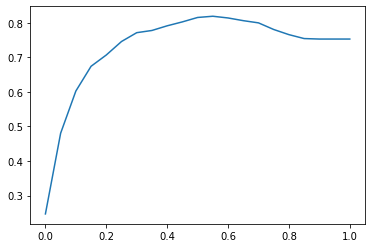

In [347]:
plt.plot(thresholds, scores)

In [348]:
from collections import Counter

In [349]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

## 4.2 Confusion Table 

In [350]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [351]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [352]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [353]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum() 

In [354]:
confusion_matrix = np.array([[tn, fp],
                            [fn, tp]])


In [355]:
confusion_matrix

array([[949, 112],
       [148, 200]])

In [356]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.67, 0.08],
       [0.11, 0.14]])

In [357]:
#from sklearn.metrics import confusion_matrix

In [358]:
#confusion_matrix(y_val, y_pred >= 0.5)

## 4.3 Precision & Recall

In [359]:
# accuracy
(tp + tn) / (tp + tn + fp + fn)

0.815471965933286

### Precision

In [360]:
# What fraction of positive predictions are correct

precision = tp / (tp + fp)

In [361]:
precision
# out of all the positive predictions 64% of the precitions are correct

0.6410256410256411

In [362]:
tp

200

In [363]:
tp + fp

312

In [364]:
200 / 312

0.6410256410256411

In [365]:
# Out of 312 positive predictions 200 of the predictions are correct

### Recall

In [366]:
# What fraction of all the positive classes are correctly classified as postivie
# Out of total postive classes, how many positive classes are correctly identified as positive

In [367]:
recall = tp / (tp + fn)

In [368]:
recall

0.5747126436781609

In [369]:
tp 

200

In [370]:
tp + fn

348

In [371]:
200 / 348

0.5747126436781609

In [372]:
# Out of 348 positive classes 200 of the positive instance are correctly classified as positive

# To get the higher value of recall 
* we need either low value for false negative 
* or high value for tp

## 4.4 ROC (Receiver Operator Charactersitic) Curves

### TPR(True Positive Rate / Sensitivity / Recall) & FPR(False Positive Rate / Specificiety)

In [373]:
# FPR (False Positive Rate)
# What fraction of the negative classses were incorrectly classified as positive
fpr = fp / (tn + fp)

# TPR (True Positive Rate or Recall)
tpr = tp / (tp + fn)

In [374]:
fpr, tpr

(0.1055607917059378, 0.5747126436781609)

In [375]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum() 
    
    scores.append((t, tp, fp, fn, tn))

In [376]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [377]:
df_scores['tpr'] =  df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] =   df_scores.fp / (df_scores.fp + df_scores.tn)

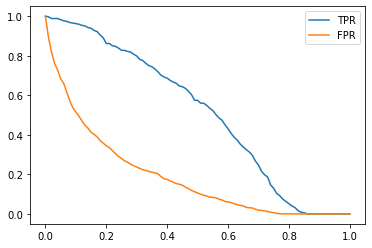

In [378]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

#### Random model

In [379]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [380]:
((y_rand >= 0.5) == y_val).mean()

0.49325762952448543

In [381]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum() 

        scores.append((t, tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['tpr'] =  df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] =   df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [382]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

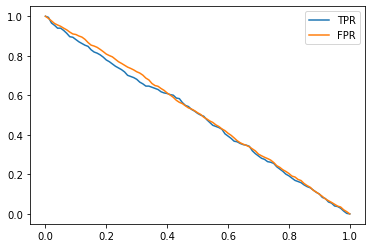

In [383]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal Model

In [384]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1061, 348)

In [385]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [386]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [387]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

0.9730305180979418

In [388]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

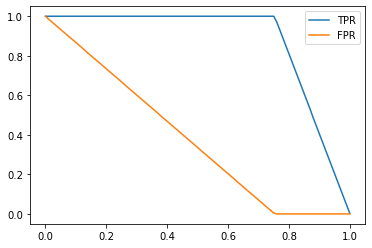

In [389]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

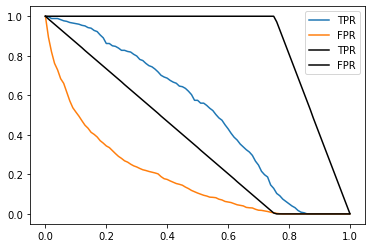

In [390]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR', color='black')

plt.legend()

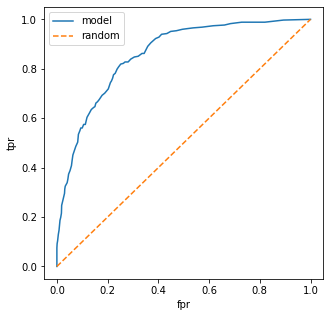

In [394]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')
# plt.plot(df_ideal.fpr, df_ideal.tpr,label='ideal', color='black')
# plt.plot(df_rand.fpr, df_rand.tpr, label='random', color='red')

plt.xlabel('fpr')
plt.ylabel('tpr')

plt.legend()

In [398]:
from sklearn.metrics import roc_curve

In [400]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

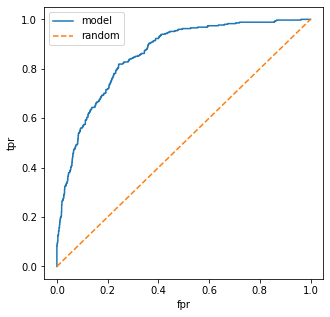

In [401]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')
# plt.plot(df_ideal.fpr, df_ideal.tpr,label='ideal', color='black')
# plt.plot(df_rand.fpr, df_rand.tpr, label='random', color='red')

plt.xlabel('fpr')
plt.ylabel('tpr')

plt.legend()

### ROC AUC

In [395]:
from sklearn.metrics import auc

In [402]:
auc(fpr, tpr)

0.8572386167896259

In [403]:
auc(df_scores.fpr, df_scores.tpr)

0.8571411160583704

In [404]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999322911588503

In [405]:
from sklearn.metrics import roc_auc_score

In [406]:
roc_auc_score(y_val, y_pred)

0.8572386167896259

In [408]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [409]:
import random

In [413]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos)-1)
    neg_ind = random.randint(0, len(neg)-1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.85757

In [414]:
n = 10000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [416]:
(pos[pos_ind] > neg[neg_ind]).mean()

0.8589

### Cross-Validation

In [448]:
def train(df, y, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [451]:
dv, model = train(df_train, y_train, C=0.001)

In [450]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records') 
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [426]:
predict(df_val, dv, model)

array([0.00899724, 0.2045188 , 0.21221736, ..., 0.13639145, 0.79976601,
       0.83740332])

In [427]:
from sklearn.model_selection import KFold

In [428]:
kfold = KFold(10, shuffle=True, random_state=1)

In [436]:
# !pip install tqdm

In [438]:
from tqdm.auto import tqdm

In [456]:
n_splits = 5
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits, shuffle=True, random_state=1)
    
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print("C=%s %.3f +- %.3f" % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.007
C=1 0.840 +- 0.008
C=5 0.841 +- 0.008
C=10 0.841 +- 0.008


In [457]:
dv, model = train(df_train, y_train, C=1)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.5060081848064465